# Distro of scores in evidence

## tbl: desc stats

In [187]:
combined_summary = evidence_df[
    ["pred_term", "assoc_evidence", "triple_evidence"]
].assign(
    evidence_count=lambda df: df.apply(
        lambda row: py_.chain(
            {
                "assoc": row["assoc_evidence"],
                "triple": row["triple_evidence"],
            }
        )
        .map(
            lambda v, k: [
                {
                    "evidence_type": EVIDENCE_LABELS[_k],
                    "evidence_count": len(_v),
                    "strength_score": sum([_["triple_score"] for _ in _v])
                    if k == "triple"
                    else sum([_["assoc_score"] for _ in _v]),
                    "mapping_score": sum([_["mapping_score"] for _ in _v]),
                    "evidence_score": sum([_["evidence_score"] for _ in _v]),
                    "pred_term": row["pred_term"],
                    "evidence_group": k,
                }
                for _k, _v in v.items()
            ]
        )
        .reduce(lambda a, b: a + b)
        .thru(lambda e: pd.DataFrame(e))
        .value(),
        axis=1,
    )
)
evidence_count_df = pd.concat(combined_summary["evidence_count"].tolist()).assign(
    pred_group=lambda df: df["pred_term"].apply(
        lambda x: epigraphdb.PRED_DIRECTIONAL_MAPPING[x]
    )
)
# TODO: refine this
print(evidence_count_df[:5])
combined_summary_df = (
    evidence_count_df.groupby(
        ["pred_group", "pred_term", "evidence_group", "evidence_type"]
    )
    .sum()
    .assign(
        avg_mapping_score=lambda df: df["mapping_score"] / df["evidence_count"],
        avg_strength_score=lambda df: df["strength_score"] / df["evidence_count"],
        avg_evidence_score=lambda df: df["evidence_score"] / df["evidence_count"],
    )
)
combined_summary_df

                evidence_type  evidence_count  strength_score  mapping_score  \
0                  Supporting               0         0.00000       0.000000   
1                    Reversal               0         0.00000       0.000000   
2  Insufficient (directional)               1         1.36009       0.454901   
3    Additional (directional)               0         0.00000       0.000000   
4                  Supporting              18        28.97569      12.467369   

   evidence_score pred_term evidence_group   pred_group  
0        0.000000    TREATS          assoc  directional  
1        0.000000    TREATS          assoc  directional  
2        0.618706    TREATS          assoc  directional  
3        0.000000    TREATS          assoc  directional  
4       20.075564    TREATS         triple  directional  


evidence_count  \
pred_group    pred_term       evidence_group evidence_type                                    
directional   AFFECTS         assoc          Additional (directional)                   289   
                                             Insufficient (directional)                3139   
                                             Reversal                                   343   
                                             Supporting                                 372   
                              triple         Reversal                                   291   
                                             Supporting                                 375   
              CAUSES          assoc          Additional (directional)                  1111   
                                             Insufficient (directional)                2732   
                                             Reversal                                   399   
                                             Supporting                                 412   
                              triple         Reversal                                   954   
                                             Supporting                                1266   
              TREATS          assoc          Additional (directional)                     0   
                                             Insufficient (directional)                 111   
                                             Reversal                                   166   
                                             Supporting                                  83   
                              triple         Reversal                                     0   
                                             Supporting                                 283   
undirectional ASSOCIATED_WITH assoc          Insufficient (non-directional)            5272   
                                             Supporting                                3106   
                              triple         Supporting                                 211   
              COEXISTS_WITH   assoc          Insufficient (non-directional)            7315   
                                             Supporting                                2401   
                              triple         Supporting                                1820   
              INTERACTS_WITH  assoc          Insufficient (non-directional)             174   
                                             Supporting                                  46   
                              triple         Supporting                                   4   

                                                                             strength_score  \
pred_group    pred_term       evidence_group evidence_type                                    
directional   AFFECTS         assoc          Additional (directional)            322.956374   
                                             Insufficient (directional)         2566.679330   
                                             Reversal                            634.069625   
                                             Supporting                          676.035558   
                              triple         Reversal                            385.622587   
                                             Supporting                          497.900691   
              CAUSES          assoc          Additional (directional)           2127.958984   
                                             Insufficient (directional)         2416.449169   
                                             Reversal                            700.798663   
                                             Supporting                          719.918579   
                              triple         Reversal                           1279.706974   
                                             Supporting                         1779.6

In [188]:
output_file = analysis_assets_dir / "evidence-retrieval-score-distro-desc-stats.tex"
combined_summary_df.assign(
    evidence_count=lambda df: df["evidence_count"].apply(lambda e: "{e:,}".format(e=e)),
    strength_score=lambda df: df.apply(
        lambda s: "{a:,.2f} ({b:,.2f})".format(
            a=s["strength_score"], b=s["avg_strength_score"]
        ),
        axis=1,
    ),
    mapping_score=lambda df: df.apply(
        lambda s: "{a:,.2f} ({b:,.2f})".format(
            a=s["mapping_score"], b=s["avg_mapping_score"]
        ),
        axis=1,
    ),
    evidence_score=lambda df: df.apply(
        lambda s: "{a:,.2f} ({b:,.2f})".format(
            a=s["evidence_score"], b=s["avg_evidence_score"]
        ),
        axis=1,
    ),
)[["evidence_count", "strength_score", "mapping_score", "evidence_score"]].to_latex(
    output_file
)

/tmp/ipykernel_13679/2874196775.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  combined_summary_df.assign(


## rel plot between evidence score and constituents

In [189]:
individual_scores_df = evidence_df[
    ["pred_term", "assoc_evidence", "triple_evidence"]
].assign(
    evidence_count=lambda df: df.apply(
        lambda row: py_.chain(
            {
                "assoc": row["assoc_evidence"],
                "triple": row["triple_evidence"],
            }
        )
        .map(
            lambda v, k: [
                {
                    "evidence_type": EVIDENCE_LABELS[_k],
                    "strength_score": ([_["triple_score"] for _ in _v])
                    if k == "triple"
                    else ([_["assoc_score"] for _ in _v]),
                    "mapping_score": ([_["mapping_score"] for _ in _v]),
                    "evidence_score": ([_["evidence_score"] for _ in _v]),
                    "pred_term": row["pred_term"],
                    "evidence_group": k,
                }
                for _k, _v in v.items()
            ]
        )
        .reduce(lambda a, b: a + b)
        .thru(lambda e: pd.DataFrame(e))
        .value(),
        axis=1,
    )
)
individual_scores_df = (
    py_.chain(
        pd.concat(individual_scores_df["evidence_count"].tolist())
        .assign(
            pred_group=lambda df: df["pred_term"].apply(
                lambda x: epigraphdb.PRED_DIRECTIONAL_MAPPING[x]
            )
        )
        .to_dict(orient="records")
    )
    .map(
        lambda items: [
            {
                "evidence_type": items["evidence_type"],
                "pred_term": items["pred_term"],
                "evidence_group": items["evidence_group"],
                "evidence_score": items["evidence_score"][idx],
                "strength_score": items["strength_score"][idx],
                "mapping_score": items["mapping_score"][idx],
            }
            for idx, _ in enumerate(items["evidence_score"])
        ]
    )
    .flatten()
    .thru(lambda e: pd.DataFrame(e))
    .value()
)
print(individual_scores_df.info())
individual_scores_df[:5]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32675 entries, 0 to 32674
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   evidence_type   32675 non-null  object 
 1   pred_term       32675 non-null  object 
 2   evidence_group  32675 non-null  object 
 3   evidence_score  32675 non-null  float64
 4   strength_score  32675 non-null  float64
 5   mapping_score   32675 non-null  float64
dtypes: float64(3), object(3)
memory usage: 1.5+ MB
None


,evidence_type,pred_term,evidence_group,evidence_score,strength_score,mapping_score
0,Insufficient (directional),TREATS,assoc,0.618706,1.360090,0.454901
1,Supporting,TREATS,triple,0.842158,1.000000,0.842158
2,Supporting,TREATS,triple,1.067562,1.477121,0.722732
3,Supporting,TREATS,triple,1.612455,2.278754,0.707604
4,Supporting,TREATS,triple,1.609770,2.301030,0.699587


In [190]:
group_counts = (
    individual_scores_df.reset_index(drop=True)
    .groupby(["evidence_group", "pred_term"])
    .size()
    .sort_values(ascending=False)
)
group_counts

evidence_group  pred_term      
assoc           COEXISTS_WITH      9716
                ASSOCIATED_WITH    8378
                CAUSES             4654
                AFFECTS            4143
triple          CAUSES             2220
                COEXISTS_WITH      1820
                AFFECTS             666
assoc           TREATS              360
triple          TREATS              283
assoc           INTERACTS_WITH      220
triple          ASSOCIATED_WITH     211
                INTERACTS_WITH        4
dtype: int64

In [191]:
plot_data = pd.concat(
    [
        individual_scores_df.assign(pred_term="all"),
        individual_scores_df[
            individual_scores_df["pred_term"].isin(
                ["AFFECTS", "CAUSES", "COEXISTS_WITH"]
            )
        ],
    ]
)[
    [
        "pred_term",
        "evidence_type",
        "evidence_group",
        "evidence_score",
        "mapping_score",
        "strength_score",
    ]
].melt(
    value_vars=["strength_score", "mapping_score"],
    id_vars=["pred_term", "evidence_group", "evidence_type", "evidence_score"],
    var_name="score_type",
    value_name="score",
)

plot_data

,pred_term,evidence_group,evidence_type,evidence_score,score_type,score
0,all,assoc,Insufficient (directional),0.618706,strength_score,1.360090
1,all,triple,Supporting,0.842158,strength_score,1.000000
2,all,triple,Supporting,1.067562,strength_score,1.477121
3,all,triple,Supporting,1.612455,strength_score,2.278754
4,all,triple,Supporting,1.609770,strength_score,2.301030
...,...,...,...,...,...,...
111783,COEXISTS_WITH,triple,Supporting,0.646121,mapping_score,0.646121
111784,COEXISTS_WITH,triple,Supporting,0.821125,mapping_score,0.631135
111785,COEXISTS_WITH,triple,Supporting,0.705564,mapping_score,0.705564
111786,COEXISTS_WITH,triple,Supporting,0.915378,mapping_score,0.703580


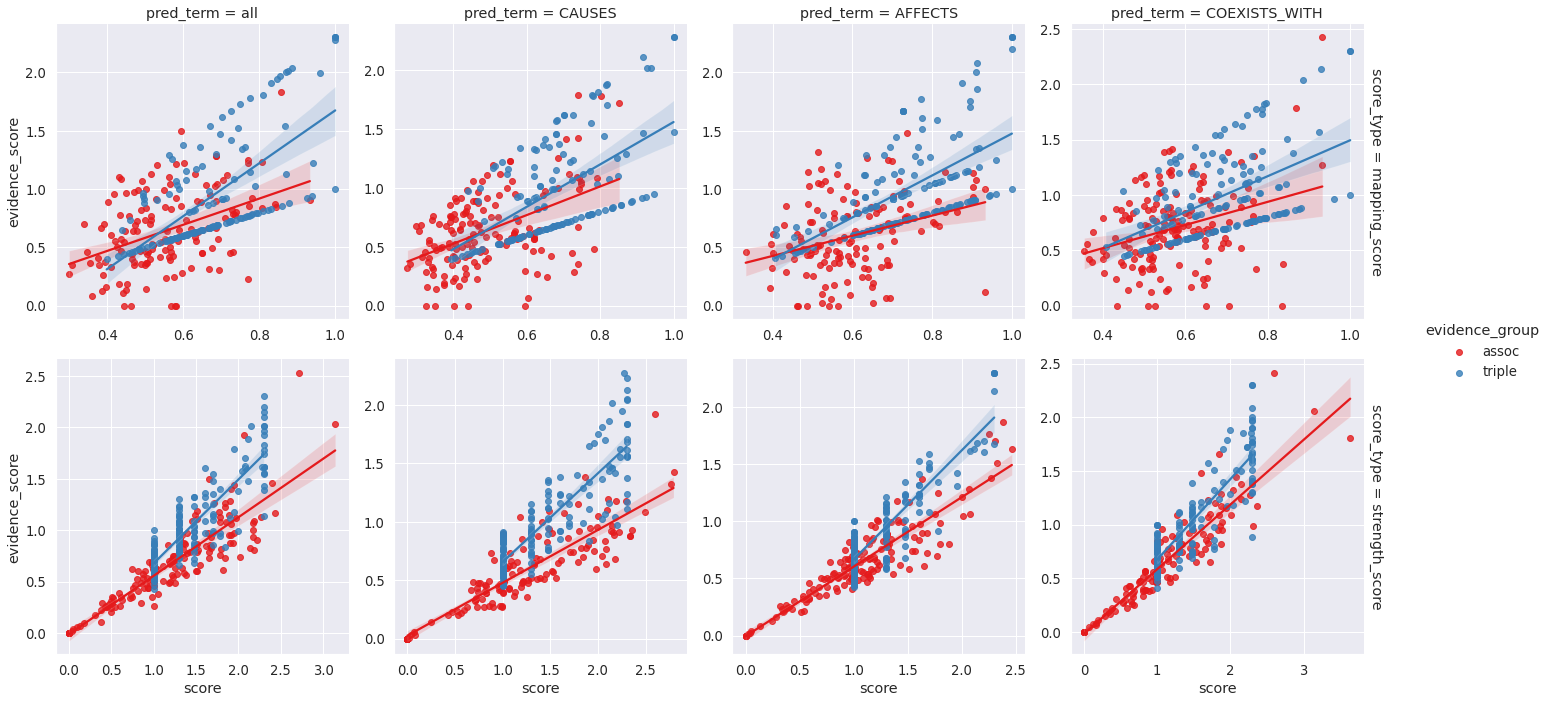

In [196]:
sns.set(font_scale=1.2)
plot = sns.lmplot(
    data=plot_data.groupby(["evidence_group", "pred_term"]).sample(
        n=300, random_state=42
    ),
    hue="evidence_group",
    y="evidence_score",
    x="score",
    col_order=["all", "CAUSES", "AFFECTS", "COEXISTS_WITH"],
    col="pred_term",
    row="score_type",
    palette="Set1",
    facet_kws={"sharex": False, "sharey": False, "margin_titles": True},
)

In [197]:
plot.fig.savefig(analysis_assets_dir / "lm-evidence-scores-all.pdf")

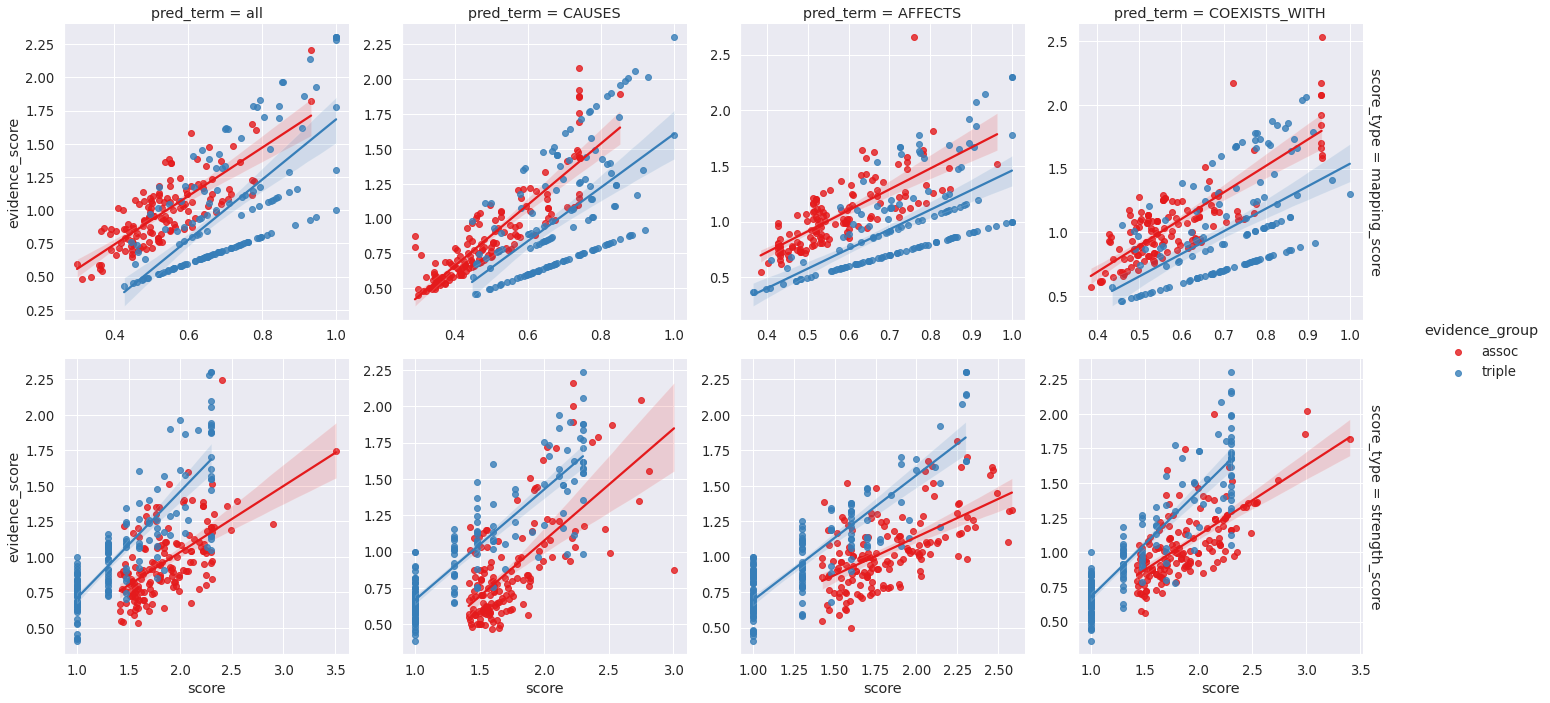

In [198]:
sns.set(font_scale=1.2)
plot = sns.lmplot(
    data=plot_data[plot_data["evidence_type"] == "Supporting"]
    .groupby(["evidence_group", "pred_term"])
    .sample(n=300, random_state=42),
    hue="evidence_group",
    y="evidence_score",
    x="score",
    col_order=["all", "CAUSES", "AFFECTS", "COEXISTS_WITH"],
    col="pred_term",
    row="score_type",
    palette="Set1",
    facet_kws={"sharex": False, "sharey": False, "margin_titles": True},
)

In [199]:
plot.fig.savefig(analysis_assets_dir / "lm-evidence-scores-supporting.pdf")

## distro plot

In [242]:
plot_data = (
    # individual_scores_df[
    #     individual_scores_df["evidence_type"].isin(["Supporting"])
    # ]
    individual_scores_df.groupby(["evidence_group", "evidence_type"])
    .sample(n=500, random_state=42)
    .melt(
        value_vars=["evidence_score", "strength_score", "mapping_score"],
        id_vars=["evidence_type", "pred_term", "evidence_group"],
        var_name="score_type",
        value_name="score",
    )
    .assign(
        pred_group=lambda df: df["pred_term"].apply(
            lambda x: epigraphdb.PRED_DIRECTIONAL_MAPPING[x]
        ),
        evidence_type=lambda df: df["evidence_type"].apply(
            lambda x: x.split(" ")[0].strip()
        ),
    )
    .assign(
        pred_group=lambda df: df["pred_group"].apply(
            lambda x: "non-directional" if x == "undirectional" else x
        )
    )
)

plot_data

,evidence_type,pred_term,evidence_group,score_type,score,pred_group
0,Additional,CAUSES,assoc,evidence_score,1.078155,directional
1,Additional,CAUSES,assoc,evidence_score,1.172033,directional
2,Additional,AFFECTS,assoc,evidence_score,0.495514,directional
3,Additional,CAUSES,assoc,evidence_score,0.955164,directional
4,Additional,AFFECTS,assoc,evidence_score,0.833582,directional
...,...,...,...,...,...,...
10495,Supporting,COEXISTS_WITH,triple,mapping_score,0.741636,non-directional
10496,Supporting,CAUSES,triple,mapping_score,1.000000,directional
10497,Supporting,COEXISTS_WITH,triple,mapping_score,0.668919,non-directional
10498,Supporting,COEXISTS_WITH,triple,mapping_score,0.559071,non-directional


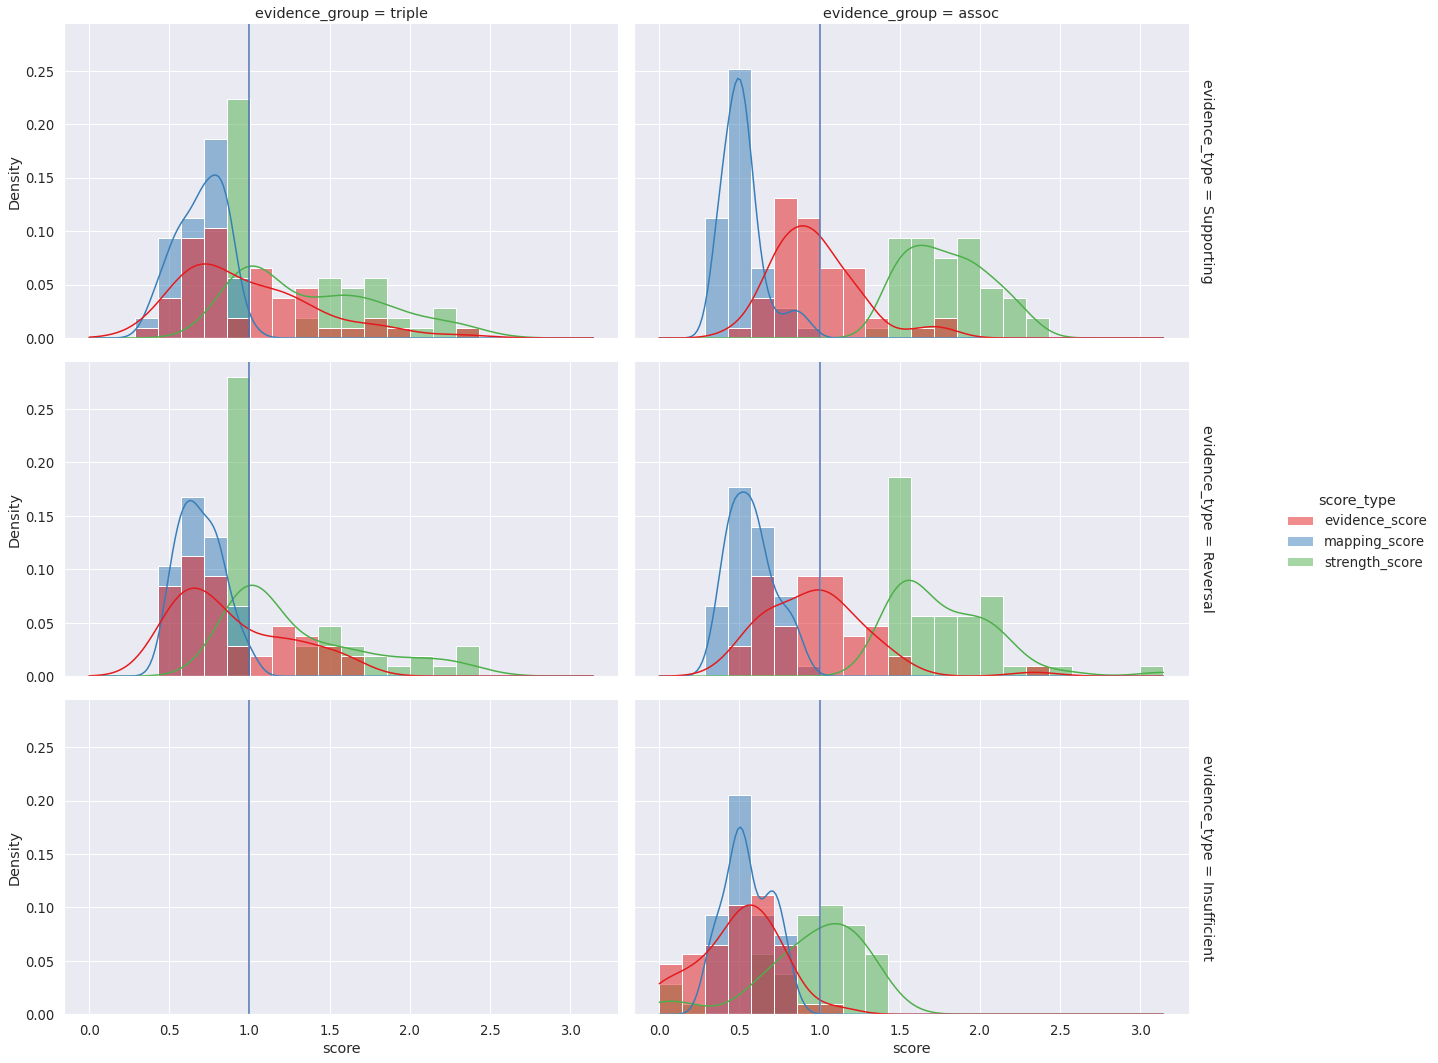

In [338]:
sns.set(font_scale=1.2)
plot = sns.displot(
    data=plot_data[
        plot_data["evidence_type"].isin(["Supporting", "Reversal", "Insufficient"])
    ]
    .groupby(["score_type", "evidence_type", "evidence_group"])
    .sample(n=50, random_state=42),
    kde=True,
    stat="density",
    x="score",
    col="evidence_group",
    col_order=[
        "triple",
        "assoc",
    ],
    row="evidence_type",
    row_order=[
        "Supporting",
        "Reversal",
        "Insufficient",
    ],
    hue="score_type",
    hue_order=[
        "evidence_score",
        "mapping_score",
        "strength_score",
    ],
    palette="Set1",
    fill=True,
    alpha=0.5,
    aspect=1.8,
    facet_kws={"sharex": True, "sharey": True, "margin_titles": True},
)

axes = [__ for _ in plot.axes for __ in _]
[_.axvline(1) for _ in axes]

plt.show()

In [339]:
plot.fig.savefig(analysis_assets_dir / "density-evidence-scores-main.pdf")

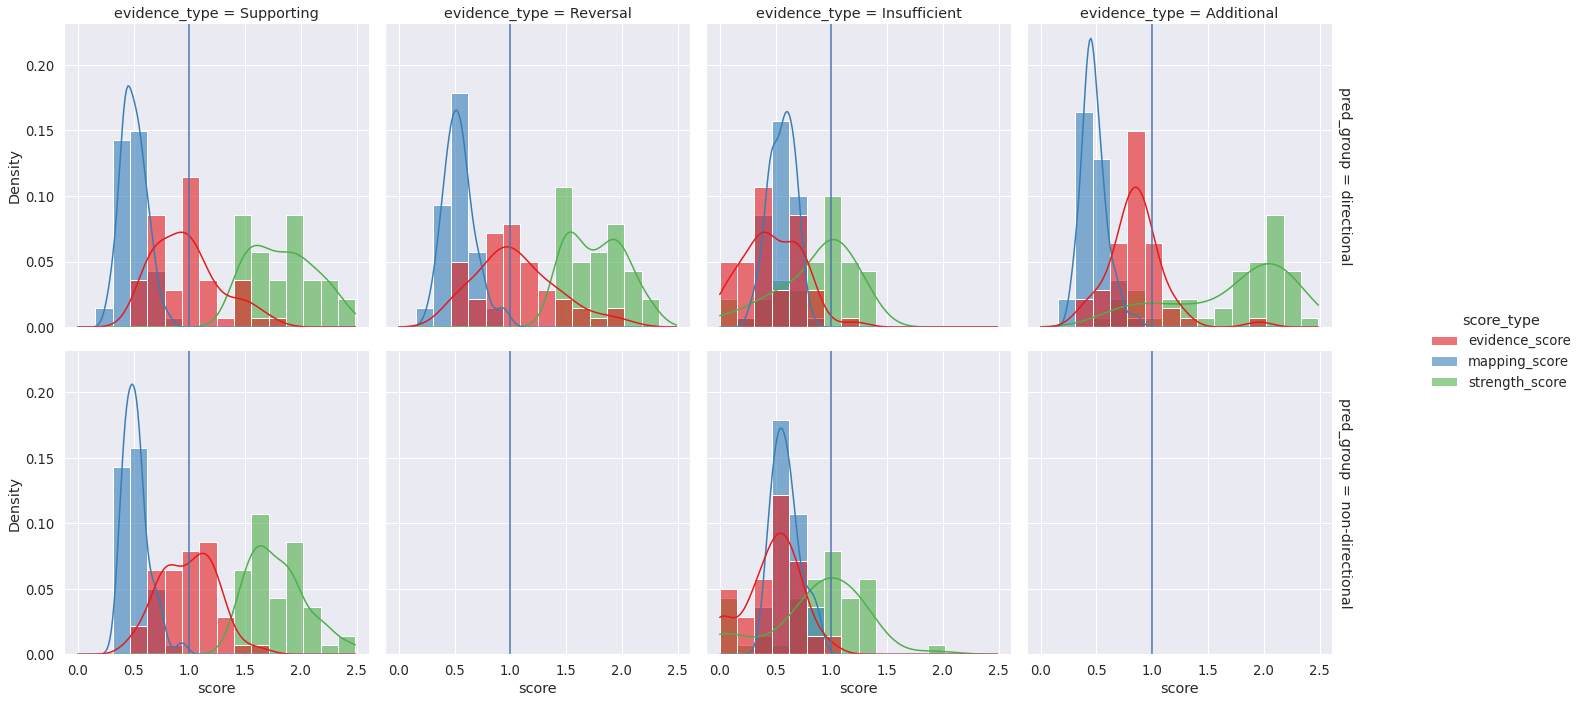

In [336]:
sns.set(font_scale=1.2)
plot = sns.displot(
    data=plot_data[plot_data["evidence_group"] == "assoc"]
    .groupby(["score_type", "evidence_type", "pred_group"])
    .sample(n=50, random_state=42),
    kde="True",
    stat="density",
    x="score",
    row="pred_group",
    row_order=["directional", "non-directional"],
    col="evidence_type",
    col_order=[
        "Supporting",
        "Reversal",
        "Insufficient",
        "Additional",
    ],
    hue="score_type",
    palette="Set1",
    fill=True,
    alpha=0.6,
    facet_kws={"sharex": True, "sharey": True, "margin_titles": True},
)

axes = [__ for _ in plot.axes for __ in _]
[_.axvline(1) for _ in axes]

plt.show()

In [337]:
plot.fig.savefig(analysis_assets_dir / "density-evidence-scores-assoc.pdf")

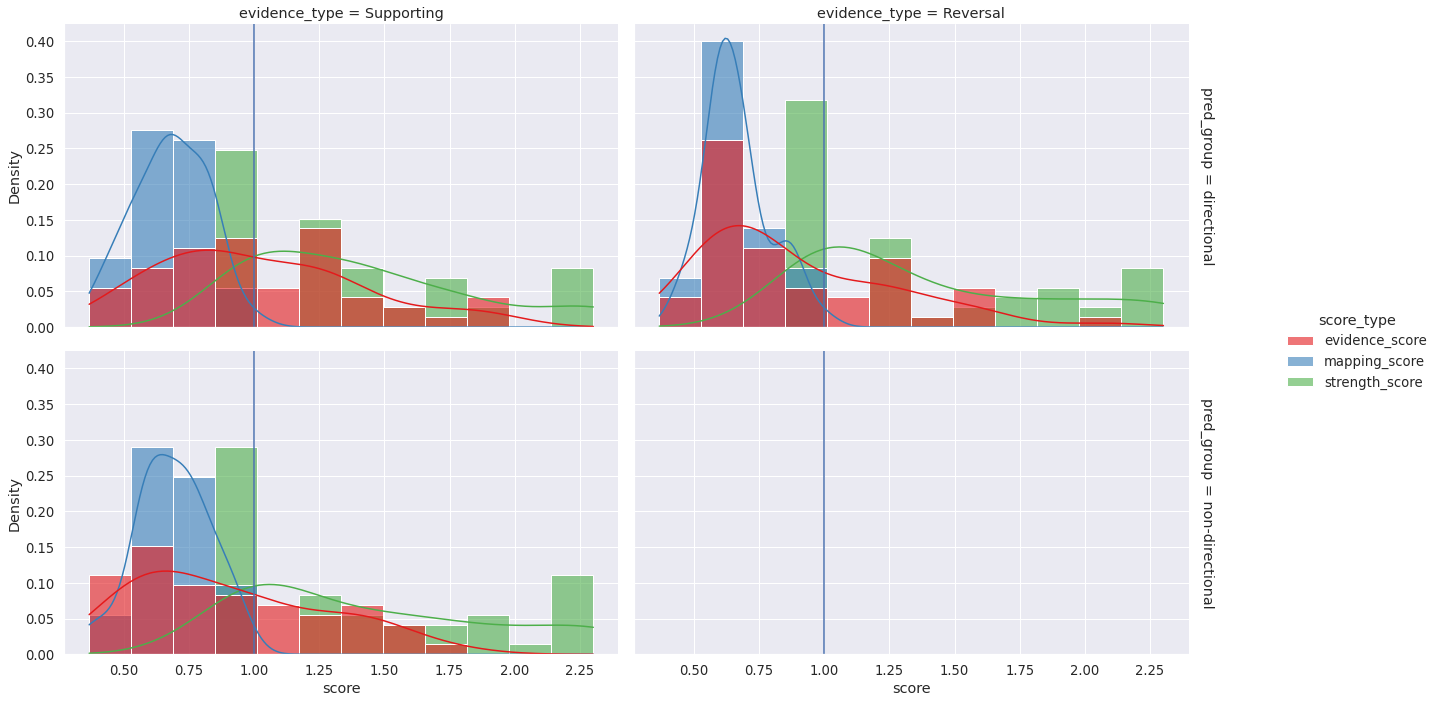

In [340]:
sns.set(font_scale=1.2)
plot = sns.displot(
    data=plot_data[plot_data["evidence_group"] == "triple"]
    .groupby(["score_type", "evidence_type", "pred_group"])
    .sample(n=50, random_state=42),
    kde=True,
    stat="density",
    x="score",
    row="pred_group",
    row_order=["directional", "non-directional"],
    col="evidence_type",
    col_order=[
        "Supporting",
        "Reversal",
    ],
    hue="score_type",
    palette="Set1",
    fill=True,
    alpha=0.6,
    aspect=1.8,
    facet_kws={"sharex": True, "sharey": True, "margin_titles": True},
)


axes = [__ for _ in plot.axes for __ in _]
[_.axvline(1) for _ in axes]

plt.show()

In [341]:
plot.fig.savefig(analysis_assets_dir / "density-evidence-scores-triple.pdf")